# 1: Imports

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import annotations

# 2: Defining Necessary Objects and Associated Functions

## 2.1 Defining Point Object

In [145]:
class Point:
  '''
  Creates a point on the surface.
    - float x: x coordinate
    - float y: y coordinate
    - list[Point] adj: list of adjacent points
    - tuple(float, float) imbal: direction of imbalance of the point
    - bool is_boundary: whether the point is a boundary point
  '''

  def __init__(self, x: float, y:float, is_boundary: bool = False):
    '''
    Constructor for Point
    '''
    self.x = x
    self.y = y
    self.adj = []
    self.adj_dirs = {}
    self.imbal = (0, 0)
    self.is_boundary = is_boundary

  def __str__(self) -> str:
    '''
    Returns a string representation of the point.
    '''
    return f'({self.x}, {self.y})'

  def add_pt(self, pt: Point) -> bool:
    '''
    Adds a point to the adjacent list and updates the adj_dirs dict. Returns
    True if successful, False otherwise.
    '''
    dist = np.sqrt((pt.x - self.x)**2 + (pt.y - self.y)**2)
    if (dist == 0):
      return False

    self.adj.append(pt)
    dir_x = (pt.x - self.x) / dist
    dir_y = (pt.y - self.y) / dist
    self.adj_dirs[pt] = (dir_x, dir_y)
    self._update_imbal()
    return True

  def remove_pt(self, pt: Point) -> bool:
    '''
    Removes a point from the adjacent list and updates the adj_dirs dict.
    Returns True if successful, False otherwise.
    '''
    if pt not in self.adj:
      return False
    self.adj.remove(pt)
    del self.adj_dirs[pt]
    self._update_imbal()
    return True

  def _update_adj_dirs(self) -> None:
    '''
    Updates the adj_dirs dict. Used as helper function for update_position
    '''
    for pt in self.adj:
      dist = np.sqrt((pt.x - self.x)**2 + (pt.y - self.y)**2)
      dir_x = (pt.x - self.x) / dist
      dir_y = (pt.y - self.y) / dist
      self.adj_dirs[pt] = (dir_x, dir_y)


  def _update_imbal(self) -> None:
    '''
    Updates the imbalance of the point using adj_dirs dict. Used as helper
    function for add_pt and remove_pt
    '''
    dir_x = 0
    dir_y = 0
    for dir in self.adj_dirs:
      dir_x += self.adj_dirs[dir][0]
      dir_y += self.adj_dirs[dir][1]
    self.imbal = (dir_x, dir_y)


  def update_position(self, x: float, y: float) -> None:
    '''
    Updates the position of the point.
    '''
    self.x = x
    self.y = y
    self._update_adj_dirs()
    self._update_imbal()

## 2.2: Defining Functions

### 2.2.1: Functions for Computing, Generating, and Processing Points

In [146]:
def connect(p1: Point, p2: Point) -> bool:
  '''
  Connects two points together. Returns True if successful, False otherwise.
  '''
  return p1.add_pt(p2) and p2.add_pt(p1)


def distance(p1: Point, p2: Point) -> float:
  '''
  Returns the distance between two points.
  '''
  return np.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)


def direction(anchor: Point, point: Point) -> tuple(float, float):
  '''
  Returns the unit vector direction from anchor to point.
  '''
  dist = distance(anchor, point)
  return (point.x - anchor.x) / dist, (point.y - anchor.y) / dist


def angle_from_x_axis(anchor: Point, point: Point) -> float:
  '''
  Returns the angle of the vector from anchor to point from the x axis,
  measured in radians and counterclockwise.
  '''
  # print("anchor:", anchor, ", point:", point)
  # print("angle from x debug", "y =", (point.y - anchor.y), ", x = ",(point.x - anchor.x))
  return np.arctan2(point.y - anchor.y, point.x - anchor.x)


def degrees_to_radians(degrees: float) -> float:
  '''
  Converts degrees to radians.
  '''
  return degrees * np.pi / 180


def radians_to_degrees(radians: float) -> float:
  '''
  Converts radians to degrees.
  '''
  return radians * 180 / np.pi


def rotate_anticlockwise(point: Point, angle: float, anchor: Point) -> Point:
  '''
  Returns a new interior point with the coordinates of point rotated
  anticlockwise by angle in randians around anchor.
  '''
  dist = distance(anchor, point)
  anchor_to_pt_angle = angle_from_x_axis(anchor, point)
  angle += anchor_to_pt_angle
  # print("rotate_anticlockwise debug: new_angle =", radians_to_degrees(angle),
  #       ", anchor_to_pt_angle =", radians_to_degrees(anchor_to_pt_angle))


  new_x = anchor.x + dist * np.cos(angle)
  new_y = anchor.y + dist * np.sin(angle)
  return Point(new_x, new_y)


def midpoint(p1: Point, p2: Point) -> Point:
  '''
  Returns a new interior point with coords that is the midpoint of p1 and p2.
  '''

  return Point((p1.x + p2.x) / 2, (p1.y + p2.y) / 2)


def intersect(anchor_1: Point, dir_1: tuple(float, float), anchor_2: Point, dir_2: tuple(float, float)) -> Point:
  '''
  Returns the point of intersection between two lines starting at anchor_1 and
  anchor_2, with directions dir_1 and dir_2 respectively.
  '''
  pt_1 = np.array([anchor_1.x, anchor_1.y])
  pt_2 = np.array([anchor_2.x, anchor_2.y])
  b = pt_2 - pt_1

  dir_1 = np.array(dir_1)
  dir_2 = np.array(dir_2)
  A = np.column_stack((dir_1, -dir_2))

  if np.linalg.det(A) == 0: # No solution or no unique solution
    return None

  t_s = np.linalg.solve(A, b)

  t = t_s[0]
  s = t_s[1]

  # print("debug intersect result with t: t =", t, ", x =", (pt_1[0] + t * dir_1[0]), ", y=", pt_1[1] + t * dir_1[1])
  # print("debug intersect result with s: s =", s, ", x =", (pt_2[0] + s * dir_2[0]),  ", y=", pt_2[1] + s * dir_2[1])

  return Point(pt_2[0] + s * dir_2[0], pt_2[1] + s * dir_2[1])



### 2.2.2: Functions for Visualization

In [147]:
def draw_line(pt_1: Point, pt_2: Point) -> None:
  '''
  Draws a line between pt_1 and pt_2.
  '''
  plt.plot([pt_1.x, pt_2.x], [pt_1.y, pt_2.y], color='blue', alpha=0.25)

# 3: Defining Value of All Points

*Note: In the future, if I am designing new nets, I might write a script that takes the input of form of an adjacency list `G(V,E)`. *

In [148]:
from math import degrees
'''
This script defines the preliminary geodesic net with 4 boundary vertices and
25 interior (potentially balanced) vertices.
'''

interior_vertices = []
interior_vertices_name = ["A12", "A11", "B1", "A42", "A41", "B4", "A32", "A31",
                          "B3", "A22", "A21", "B2",
                          "P", "F1", "F2", "F3", "F4",
                          "C1", "C2", "C3", "C4",
                          "E1", "E2", "E3", "E4"]
boundary_vertices = []
boundary_vertices_name = ["D1", "D2", "D3", "D4"]


#######################
# Interior Vertices 1
#######################

# Defining and connecting the dodecagon (A and B points)

edge_length = 10 # Modify depending on the optimization

a12 = Point(edge_length, 0)
interior_vertices.append(a12)
a11 = Point(0, 0)
interior_vertices.append(a11)
connect(a12, a11)

angle1 = degrees_to_radians(165)
angle2 = degrees_to_radians(120)

for i in range(1, 11):
  if (i - 2) % 3 == 0:
    p = rotate_anticlockwise(interior_vertices[-2], angle2, interior_vertices[-1])
  else:
    p = rotate_anticlockwise(interior_vertices[-2], angle1, interior_vertices[-1])
  interior_vertices.append(p)
  connect(interior_vertices[-2], interior_vertices[-1])

connect(interior_vertices[0], interior_vertices[-1])

# Defining and connecting the 5 vertices inside the dodecagon

## Midpoint P
i = interior_vertices_name.index("B1")
j = interior_vertices_name.index("B3")

p = midpoint(interior_vertices[i], interior_vertices[j])
interior_vertices.append(p)

## F points

lst = [("A11", "A12"), ("A21", "A22"), ("A31", "A32"), ("A41", "A42")]
# label name to iterate on

for label in lst:
  i1 = interior_vertices_name.index(label[0])
  i2 = interior_vertices_name.index(label[1])
  f = midpoint(interior_vertices[i1], interior_vertices[i2])

  dist = distance(f, interior_vertices[i1])
  dist = dist / np.sqrt(3)
  dir = direction(f, p)
  dir = (dir[0] * dist, dir[1] * dist)
  f.update_position(f.x + dir[0], f.y + dir[1])

  interior_vertices.append(f)

  connect(interior_vertices[i1], f)
  connect(interior_vertices[i2], f)
  connect(p, f)

# Defining and connecting the 4 vertices close to the B vertices (C points)

t = 0.0115 # Modify depending on the optimization

lst = [("B1", "A42", "A11"), ("B2", "A12", "A21"), ("B3", "A22", "A31"),
       ("B4", "A32", "A41")] # label name to iterate on

for label in lst:
  i = interior_vertices_name.index(label[0])

  j1 = interior_vertices_name.index(label[1])
  j2 = interior_vertices_name.index(label[2])

  x = (1 + t) * interior_vertices[i].x - t * p.x
  y = (1 + t) * interior_vertices[i].y - t * p.y
  c = Point(x, y)
  interior_vertices.append(c)
  connect(interior_vertices[i], c)
  connect(interior_vertices[j1], c)
  connect(interior_vertices[j2], c)


#######################
# Boundary Vertices (D points)
#######################

lst = [("C1", "C2", "A42", "A21", "A11", "A12"),
       ("C2", "C3", "A12", "A31", "A21", "A22"),
       ("C3", "C4", "A22", "A41", "A31", "A32"),
       ("C4", "C1", "A32", "A11", "A41", "A42")]
       # label name to iterate on

for label in lst:
  i1 = interior_vertices_name.index(label[0])
  pt_1 = interior_vertices[i1]
  i2 = interior_vertices_name.index(label[1])
  pt_2 = interior_vertices[i2]

  j1 = interior_vertices_name.index(label[2])
  anchor_1 = interior_vertices[j1]
  j2 = interior_vertices_name.index(label[3])
  anchor_2 = interior_vertices[j2]

  k1 = interior_vertices_name.index(label[4])
  pt_3 = interior_vertices[k1]
  k2 = interior_vertices_name.index(label[5])
  pt_4 = interior_vertices[k2]

  dir_1 = direction(anchor_1, pt_1)
  dir_2 = direction(anchor_2, pt_2)
  # print("debug Boundary Vertices: dir_1 =", dir_1, ", dir_2 =", dir_2)

  d = intersect(anchor_1, dir_1, anchor_2, dir_2)

  if (d == None):
    print("Error: No intersection found")
    exit()

  d.is_boundary = True
  # print("debug Boundary Vertices: D =", d)
  boundary_vertices.append(d)
  connect(pt_1, d)
  connect(pt_2, d)
  connect(pt_3, d)
  connect(pt_4, d)


#######################
# Interior Vertices 2 (E points)
#######################

i1 = boundary_vertices_name.index("D1")
i2 = boundary_vertices_name.index("D2")
i3 = boundary_vertices_name.index("D3")
i4 = boundary_vertices_name.index("D4")
d1 = boundary_vertices[i1]
d2 = boundary_vertices[i2]
d3 = boundary_vertices[i3]
d4 = boundary_vertices[i4]

j = interior_vertices_name.index("P")
p = interior_vertices[j]

k1 = interior_vertices_name.index("C1")
k2 = interior_vertices_name.index("C2")
k3 = interior_vertices_name.index("C3")
k4 = interior_vertices_name.index("C4")

c1 = interior_vertices[k1]
c2 = interior_vertices[k2]
c3 = interior_vertices[k3]
c4 = interior_vertices[k4]


angle3 = degrees_to_radians(75)

dir_11 = (-1, np.tan(angle3))
dir_21 = (1, np.tan(angle3))
dir_31 = (1, -np.tan(angle3))
dir_41 = (-1, -np.tan(angle3))

dir_12 = (-1, -1)
dir_22 = (1, -1)
dir_32 = (1, 1)
dir_42 = (-1, 1)

e1 = intersect(d1, dir_11, p, dir_12)
connect(d1, e1)
connect(d4, e1)
connect(c1, e1)
interior_vertices.append(e1)
e2 = intersect(d1, dir_21, p, dir_22)
connect(d2, e2)
connect(d1, e2)
connect(c2, e2)
interior_vertices.append(e2)
e3 = intersect(d3, dir_31, p, dir_32)
connect(d3, e3)
connect(d2, e3)
connect(c3, e3)
interior_vertices.append(e3)
e4 = intersect(d3, dir_41, p, dir_42)
connect(d4, e4)
connect(d3, e4)
connect(c4, e4)
interior_vertices.append(e4)

Visualizing the Points

<function matplotlib.pyplot.show(close=None, block=None)>

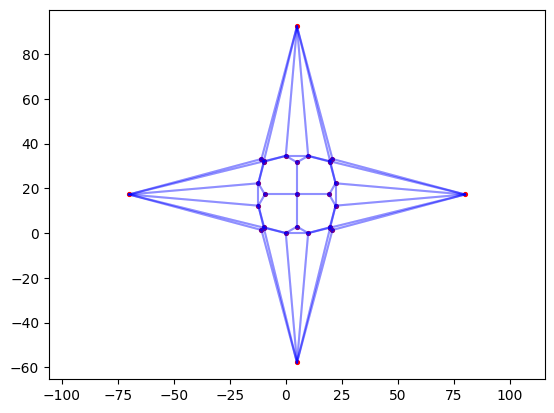

In [149]:
coords_int = []
for i in range(len(interior_vertices)):
  coords_int.append((interior_vertices[i].x, interior_vertices[i].y))

coords_bound = []
for i in range(len(boundary_vertices)):
  coords_bound.append((boundary_vertices[i].x, boundary_vertices[i].y))

plt.scatter(*zip(*coords_int), s=30, marker=".", color="purple")
plt.scatter(*zip(*coords_bound), s=30, marker=".", color="red")

# Might need BFS/DFS to traverse whole graph and draw all edges
# Alternative is draw all edges twice (current implementation)

for i in range(len(interior_vertices)):
  adj_pts = interior_vertices[i].adj
  for j in range(len(adj_pts)):
    draw_line(interior_vertices[i], adj_pts[j])

for i in range(len(boundary_vertices)):
  adj_pts = boundary_vertices[i].adj
  for j in range(len(adj_pts)):
    draw_line(boundary_vertices[i], adj_pts[j])

plt.axis('equal')
plt.show

In [150]:
i = interior_vertices_name.index("B1")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("C1")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("E1")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("A11")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("A12")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("F1")
p = interior_vertices[i]
print(p.imbal)

# Check imbalance of some representative points before optimizing

(np.float64(-4.107825191113079e-15), np.float64(4.440892098500626e-15))
(np.float64(1.6764367671839864e-14), np.float64(-1.6764367671839864e-14))
(np.float64(-1.1879386363489175e-14), np.float64(1.2989609388114332e-14))
(np.float64(0.01526747158519115), np.float64(0.0015996337554474716))
(np.float64(-0.015267471585195494), np.float64(0.001599633755444363))
(np.float64(5.819775926220233e-16), np.float64(0.0))


# 4: Optimization Algorithm

## 4.1: Defining Necessary Functions

In [151]:
def optimize_direction(int_pts: list[Point], bdry_pts: list[Point], alpha: np.float64=0.001, niter: int=1000) -> None:
  '''
  Runs an optimization algorithm the points in int_pts using the direction
  descent method. Each iteration will perturb by a scale of alpha; algorithm
  will runn niter iterations.
  '''

  for i in range(niter):
    for pt in int_pts:
      pt.update_position(pt.x + alpha * pt.imbal[0], pt.y + alpha * pt.imbal[1])


## 4.2: Algorithm Body

In [158]:
optimize_direction(interior_vertices, boundary_vertices, alpha=0.01, niter = 500000)

<function matplotlib.pyplot.show(close=None, block=None)>

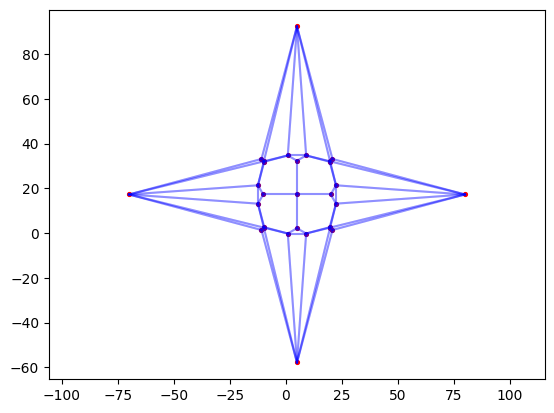

In [159]:
# Revisualize after iteration

plt.clf()
plt.close()
coords_int = []
for i in range(len(interior_vertices)):
  coords_int.append((interior_vertices[i].x, interior_vertices[i].y))

coords_bound = []
for i in range(len(boundary_vertices)):
  coords_bound.append((boundary_vertices[i].x, boundary_vertices[i].y))

plt.scatter(*zip(*coords_int), s=30, marker=".", color="purple")
plt.scatter(*zip(*coords_bound), s=30, marker=".", color="red")

# Might need BFS/DFS to traverse whole graph and draw all edges
# Alternative is draw all edges twice (current implementation)

for i in range(len(interior_vertices)):
  adj_pts = interior_vertices[i].adj
  for j in range(len(adj_pts)):
    draw_line(interior_vertices[i], adj_pts[j])

for i in range(len(boundary_vertices)):
  adj_pts = boundary_vertices[i].adj
  for j in range(len(adj_pts)):
    draw_line(boundary_vertices[i], adj_pts[j])

plt.axis('equal')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

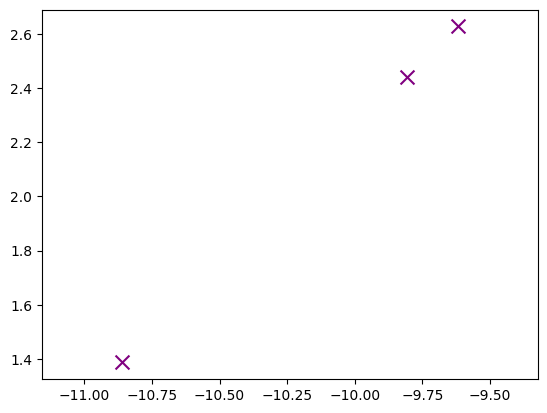

In [160]:
# Close_up of B1, C1, E1

plt.clf()
plt.close()
i = interior_vertices_name.index("B1")
j = interior_vertices_name.index("C1")
k = interior_vertices_name.index("E1")
coords_int = []
coords_int.append((interior_vertices[i].x, interior_vertices[i].y))
coords_int.append((interior_vertices[j].x, interior_vertices[j].y))
coords_int.append((interior_vertices[k].x, interior_vertices[k].y))

plt.scatter(*zip(*coords_int), s=100, marker="x", color="purple")

# Might need BFS/DFS to traverse whole graph and draw all edges
# Alternative is draw all edges twice (current implementation)

plt.axis('equal')
plt.show

In [161]:
i = interior_vertices_name.index("B1")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("C1")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("E1")
p = interior_vertices[i]
print(p.imbal)
# Check imbalance of above points

(np.float64(-8.79296635503124e-14), np.float64(-2.220446049250313e-14))
(np.float64(-3.9968028886505635e-14), np.float64(-2.2093438190040615e-14))
(np.float64(8.870681966755001e-14), np.float64(-1.1102230246251565e-14))


<function matplotlib.pyplot.show(close=None, block=None)>

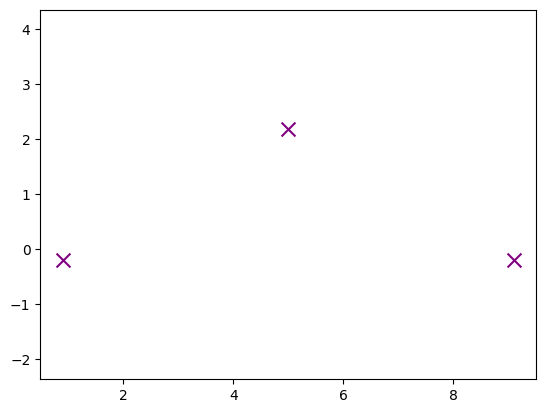

In [162]:
# Close_up of A11, A12, F1

plt.clf()
plt.close()
i = interior_vertices_name.index("A11")
j = interior_vertices_name.index("A12")
k = interior_vertices_name.index("F1")
coords_int = []
coords_int.append((interior_vertices[i].x, interior_vertices[i].y))
coords_int.append((interior_vertices[j].x, interior_vertices[j].y))
coords_int.append((interior_vertices[k].x, interior_vertices[k].y))

plt.scatter(*zip(*coords_int), s=100, marker="x", color="purple")

# Might need BFS/DFS to traverse whole graph and draw all edges
# Alternative is draw all edges twice (current implementation)

plt.axis('equal')
plt.show

In [163]:
i = interior_vertices_name.index("A11")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("A12")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("F1")
p = interior_vertices[i]
print(p.imbal)
# Check imbalance of above points

(np.float64(5.4539706084710815e-15), np.float64(-1.3322676295501878e-15))
(np.float64(-8.880396418220471e-14), np.float64(-1.3322676295501878e-15))
(np.float64(3.8324363855427694e-14), np.float64(-2.220446049250313e-14))
